# Stochastic approaches to integration

Here we will revisit our discussion of numerical integration, and think about how we can use sampling to approximate integrals.

## Expectation values from sampling

Last lecture we discussed how to sample from probability distributions, but we totally avoided the question of why we might want to do such sampling.  The obvious answer is that we want to understand spome property of the distribution.

For example, when we were discussing the hard disc gas we argued that because of the ergodic dynamics all valid configurations were equally likely.  Thus we should be able to calculate the pair correlation functions by simply sampling all valid configurations.

In the end, anything we end up calculating can be expressed as some sort of expectation value.  Suppose we have a set of states $j$, which occur with probability $p_j$.  We then have some quantity $X_j$ which depends on the state.  The expectation value is
\begin{equation}
\langle X\rangle = \sum_j p_j X_j.
\end{equation}
We can approximate this expectation value by taking a sample of $N$ states,
\begin{equation}
X^{\rm est}_N = \frac{1}{N} \sum_{\alpha=1}^N X_{j_\alpha}
\end{equation}
here $\alpha$ labels the realizations, and $j_\alpha$ is the state in that realization.  We will often shorten this to
\begin{equation}
X^{\rm est}_N = \frac{1}{N} \sum_{\alpha=1}^N X_\alpha.
\end{equation}
This notation is somewhat confusing, though, as the probability distribution doesn't appear anywhere in it.  The point is, however, that the $j$'s are drawn from it.
One often calls $X^{\rm est}_N$ the sample mean, and $\langle X\rangle$ the population mean.  

Here is an example.  We are going to generate $j$'s between 1 and 10, with probablity distribution $p_j\propto j$

In [2]:
using StatsBase

In [3]:
function ts()
    sample(1:10,Weights([j for j in 1:10]))
end

ts (generic function with 1 method)

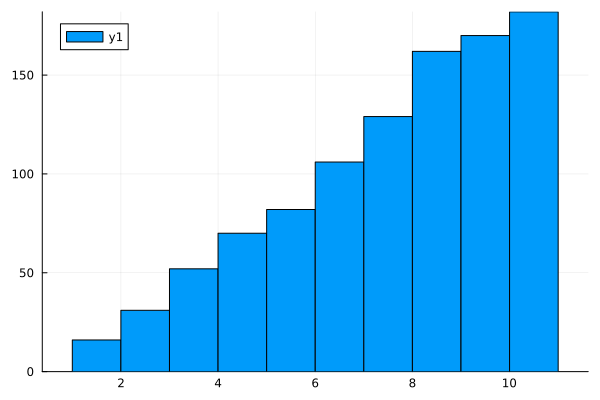

In [4]:
using Plots
histogram([ts() for j in 1:1000])

Lets now estimate 
\begin{align}
\langle j\rangle &= \sum_j p_j j\\
&= \frac{\sum_j j^2}{\sum_j j}\\
\end{align}

In [5]:
# Exact answer
exactmean=sum(j^2 for j in 1:10)/sum(j for j in 1:10)

7.0

In [6]:
function approxmean(numsamples)
    result=0.
    for j in 1:numsamples
        result+=ts()
    end
    return result/numsamples
end

approxmean(100)

6.61

Every time we do this we get a different answer.  Here is the distribution of answers

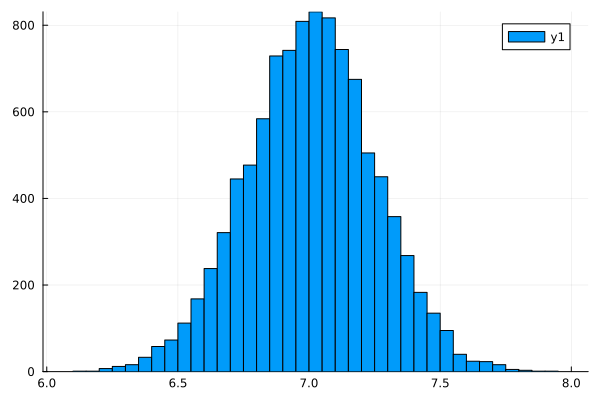

In [7]:
histogram([approxmean(100) for j in 1:10000])

If I sample more times, I get a smaller spread

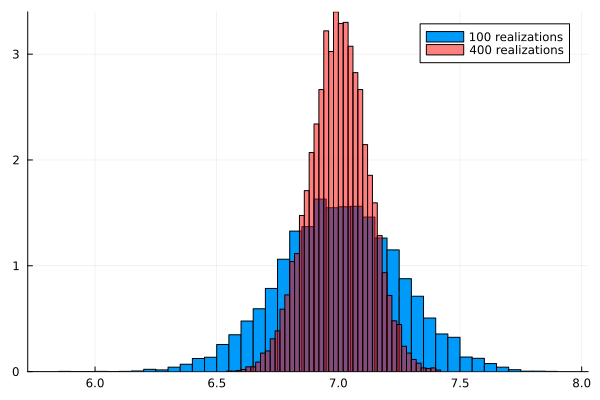

In [8]:
histogram([approxmean(100) for j in 1:10000],label="100 realizations",normed=true)
histogram!([approxmean(400) for j in 1:10000],label="400 realizations",
    normed=true,color=RGBA(1,0,0,0.5))

We understand this result by looking at the expectation value and standard deviation of our sample estimator

\begin{align}
\langle X^{\rm est}_N \rangle &= \frac{1}{N} \sum_{\alpha=1}^N \langle X_\alpha\rangle\\
&= \langle X\rangle
\end{align}
Thus on average the estimator is a good approximation to the mean.  The spread is
\begin{align}
\langle (X^{\rm est}_N - \bar{X})^2 \rangle &= \frac{1}{N^2} 
\sum_{\alpha=1}^N \sum_{\beta=1}^N \langle (X_\alpha-\bar X)(X_\beta-\bar X\rangle
\end{align}
where for notational simplicity we have written $\bar{X}=\langle X\rangle$.

Now if the samples are uncorrelated the only non-zero terms have $\alpha=\beta$ and the sum becomes
\begin{align}
\langle (X^{\rm est}_N - \bar{X})^2 \rangle 
&=\frac{1}{N^2} \sum_{\alpha=1}^N \langle (X_\alpha-\bar X)^\rangle\\
&=\frac{\sigma^2}{N}
\end{align}
where
\begin{align}
\sigma^2 &= \langle X^2\rangle-\langle X\rangle^2
\end{align}
is the population standard deviation.

Lets see if this works

In [9]:
sigma=sqrt(sum(j*(j-exactmean)^2 for j in 1:10)/sum(j for j in 1:10))

2.449489742783178

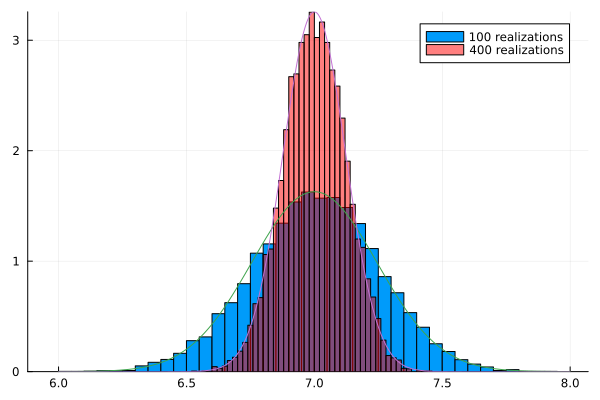

In [10]:
histogram([approxmean(100) for j in 1:10000],label="100 realizations",normed=true)
histogram!([approxmean(400) for j in 1:10000],label="400 realizations",
    normed=true,color=RGBA(1,0,0,0.5))
plot!(j->exp(-(j-exactmean)^2/2(sigma^2/100))*sqrt(100/(2*pi*sigma^2)),6,8,label="")
plot!(j->exp(-(j-exactmean)^2/2(sigma^2/400))*sqrt(400/(2*pi*sigma^2)),6,8,label="")

Now typically we don't know what the population standard deviation is.  However, we can estimate it from the sample standard deviation.  Intuitively, it should be well approximated by the sample standard deviation.

More precisely, however
\begin{align}
\sigma_{\rm sample}^2&= \frac{1}{N}\sum_\alpha (X_\alpha-X_N^{\rm est})^2\\
&=\frac{1}{N}\sum_\alpha (X_\alpha-\bar X)^2 
+ 2 X_\alpha (\bar X -X_N^{\rm est})
 - (\bar{X}^2- (X_N^{\rm est})^2)\\
  &= \left(\frac{1}{N}\sum_\alpha (X_\alpha-\bar X)^2\right) +2 X_N^{\rm est}\bar X -2 (X_N^{\rm est})^2 - \bar X^2+(X_N^{\rm est})^2\\
&= \left(\frac{1}{N}\sum_\alpha (X_\alpha-\bar X)^2\right) +2 X_N^{\rm est}\bar X - (X_N^{\rm est})^2 - \bar X^2
\end{align}

On average we then have
\begin{align}
\langle \sigma_{\rm sample}^2\rangle &= \sigma^2 +\bar X^2 - \langle (X_N^{\rm est})^2 \langle (X_N^{\rm est})^2\rangle-\bar X^2\\
&= \sigma^2 -\frac{\sigma^2}{N}.
\end{align}
Thus our best estimate of the population standard deviation is
\begin{align}
\sigma^2&=\langle\sigma_{\rm sample}^2\rangle\left(\frac{N}{N-1}\right)\\
&=\frac{1}{N-1} \sum_\alpha (X_\alpha-X_N^{\rm est})^2
\end{align}

We are always going to be using a large enough $N$ that we don't really need to worry about the difference between $N$ and $N-1$.  

To reitterate, to estimate the error of our mean, we first calculate the standard deviation of our sample.  We then divide by the square root of the number of realizations (or $N-1$).

\begin{equation}
\mbox{estimated error in mean}\approx \frac{\sigma_{\rm{sample}}}{\sqrt{N-1}}
\end{equation}

## Correlated Sampling

Now what happens if we have a correlated sample.  For example, we use a Markov chain to sample the same distribution:

In [11]:
function markov_walk(initialj,distribution,numsteps)
    j=initialj
    path=[j]
    for i in 1:numsteps
        # randomly propose left or right
        if rand()<1/2 # propose left
            if j==1 || rand()>min(1,distribution[j-1]/distribution[j])
                push!(path,j)
                continue # go to next step of i loop
            end
            j-=1
            push!(path,j)
            continue
        end
        # We have chosen right
        if j==length(distribution) || 
                rand()>min(1,distribution[j+1]/distribution[j])
            push!(path,j)
            continue
        end
        j+=1
        push!(path,j)
    end
    path
end   

markov_walk (generic function with 1 method)

Note:  We don't need the `min` statements.  
    
    rand()>min(1,distribution[j-1]/distribution[j])

is 100% equivalent to 

    rand()>distribution[j-1]/distribution[j]

this is because `rand()` returns a value between 0 and 1 -- which is always less than 1.  Removing the `min` statement makes it a bit more efficient 

In [12]:
function markov_walk(initialj,distribution,numsteps)
    j=initialj
    path=[j]
    for i in 1:numsteps
        # randomly propose left or right
        if rand()<1/2 # propose left
            if j==1 || rand()>distribution[j-1]/distribution[j]
                push!(path,j)
                continue # go to next step of i loop
            end
            j-=1
            push!(path,j)
            continue
        end
        # We have chosen right
        if j==length(distribution) || rand()>distribution[j+1]
            push!(path,j)
            continue
        end
        j+=1
        push!(path,j)
    end
    path
end   

markov_walk (generic function with 1 method)

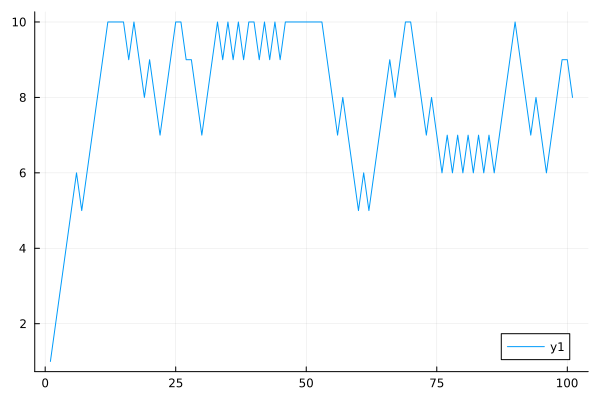

In [13]:
plot(markov_walk(1,1:10,100))

If we run many such Markov chains, and average the end number, we should get a good estimate of the expectation value

In [14]:
function markov_mean(start,numsteps,numrealizations)
    mean=0.
    for j in 1:numrealizations
        mean+=markov_walk(start,1:10,numsteps)[end]
    end
    return mean/numrealizations
end

markov_mean(1,100,1000)

7.077

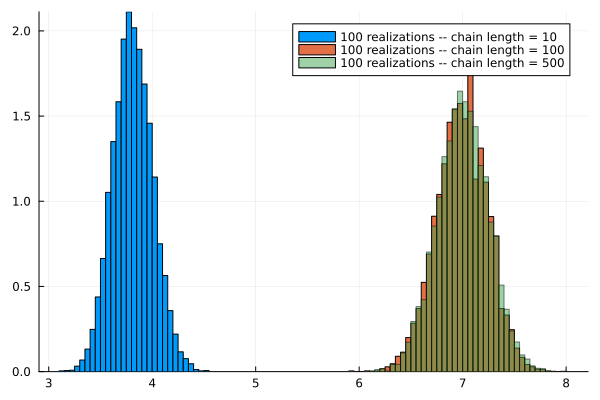

In [16]:
histogram([markov_mean(1,10,100) for j in 1:10000],label="100 realizations -- chain length = 10",normed=true)
histogram!([markov_mean(1,100,100) for j in 1:10000],label="100 realizations -- chain length = 100",normed=true)
histogram!([markov_mean(1,500,100) for j in 1:10000],label="100 realizations -- chain length = 500",normed=true,alpha=0.5)


There are three numbers here:  How long we run the Markov chain (10,100,500), and how many realizations we average for each mean (100), and how many means we calculate to make a histogram (1000).

As you can see, as long as we run the Markov chain long enough we get the same distribution.  The width should be the same as we found for our other sampling approach

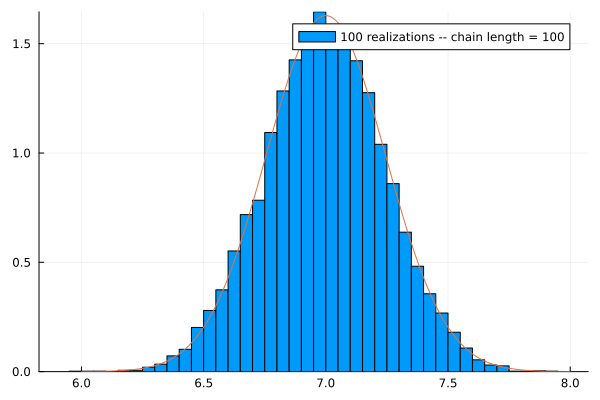

In [14]:
histogram([markov_mean(1,100,100) for j in 1:10000],label="100 realizations -- chain length = 100",normed=true)
plot!(j->exp(-(j-exactmean)^2/2(sigma^2/100))*sqrt(100/(2*pi*sigma^2)),6,8,label="")

What we can do here that is novel, however, is we can use all of the samples generated during the Markov chain.  The first few are biased, but the later ones give (correlated) samples from our desired distribution.

In [15]:
function markov_mean2(start,numsteps,discard)
    realizations=markov_walk(start,1:10,numsteps)
    mean=0.
    count=0
    for α in discard+1:numsteps+1
        mean+=realizations[α]
        count+=1
    end
    return mean/count
end

markov_mean2 (generic function with 1 method)

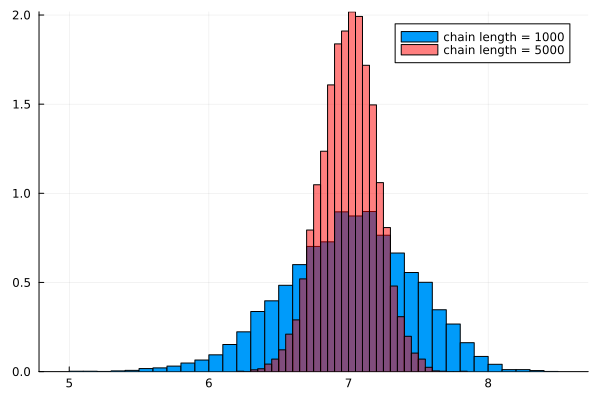

In [16]:
histogram([markov_mean2(1,1000,100) for j in 1:10000],label="chain length = 1000",normed=true)
histogram!([markov_mean2(1,5000,100) for j in 1:10000],label="chain length = 5000",normed=true,color=RGBA(1,0,0,0.5))

This is somewhat convenient.  We just run one Markov chain, and estimate the mean by averaging the time-series that we produce.

Estimating the error, however is more complicated, since our samples are correlated.  Heuristically, there is a "correlation time", and samples separated by more than the correlation time are uncorrelated.  Suppose the correlation time was 10.  We could just take every 10th sample, and then we would have independent samples and use our standard result. 

We can quantify the correlations by the expectation value 
$C_{\alpha\beta}=\langle j_\alpha j_\beta\rangle$.  This means we run our Markov chain.  Multiply the $\alpha$'th value of $j$ by the $\beta$'th.  We then repeat this numerical experiment over and over again.

Once things are in steady state we expect $C_{\alpha\beta}=C(\alpha-\beta)$ to only be a function of the difference between these times.  Thus it makes sense to average over multiple times
\begin{align}
C(\delta)&=\frac{1}{N}\sum_{\alpha} \langle j_{\alpha+\delta} j_\alpha\rangle\\
&\approx \frac{1}{N}\sum_{\alpha} j_{\alpha+\delta} j_\alpha
\end{align}
where we approximate it by the value in one realization of the Markov chain.

We can calculate the correlation function in the same way that we did for the velocities in our hard disk problem:

In [17]:
using LinearAlgebra
using Statistics
function autocorrelation(values,largestsep)
    timesteps=length(values)
    [(values[1+j:end]⋅values[1:end-j])/(timesteps-j) for j in 0:largestsep]
end

autocorrelation (generic function with 1 method)

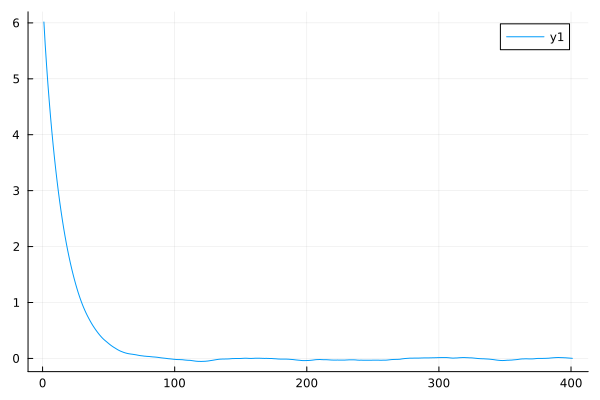

In [18]:
chain1=markov_walk(1,1:10,1000000)
cor1=autocorrelation(chain1[100:end],400)
chainmean1=mean(chain1[100:end])
plot(cor1.-(chainmean1^2))

This appears to be well modelled by an exponential

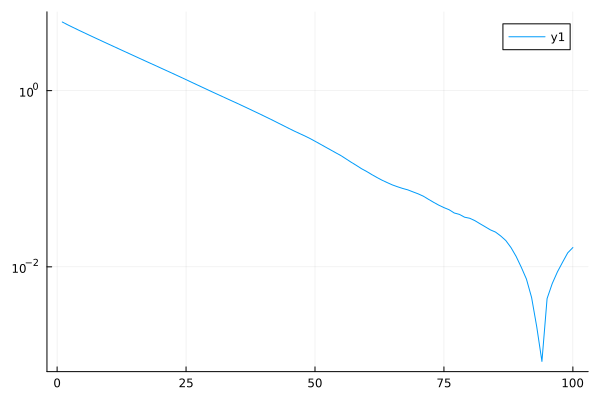

In [19]:
plot(abs.(cor1.-(chainmean1^2))[1:100],yscale=:log10)

We could fit this to an exponential to extract the correlation time.  Here, however, is a slightly simpler strategy, which gives us a number even if the correlations are non-exponential.  We define
\begin{equation}
\tau=\sum_{j=1}^\infty \frac{C_j-C_\infty}{C_0-C_\infty}
\end{equation}
which comes from thinking about exponential sequencey, where $m_j=A e^{-j/\tau}$.  These give
\begin{equation}
\sum_{j=1}^\infty e^{j/\tau}=\frac{1}{e^{1/\tau}-1}\approx\tau.
\end{equation}

We are also implicitly assuming that for infinite time separation the samples are uncorrelated, so $C_\infty=\langle j\rangle^2$:

In [23]:
tau1=sum((cor1[j]-chainmean1^2) for j in 1:length(cor1))/(cor1[1]-chainmean1^2)

15.486621152952669

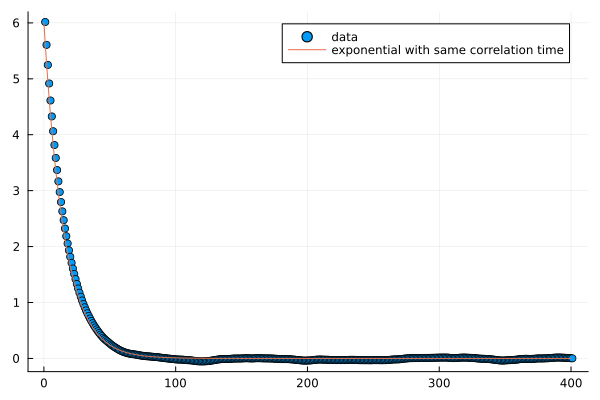

In [24]:
scatter(cor1.-(chainmean1^2),label="data")
plot!(t->(cor1[1]-(chainmean1^2))*exp(-t/tau1),0,400,label="exponential with same correlation time")

The correlation time tends to also give the equilibration time, a result known as the fluctuation-dissipation theorem,

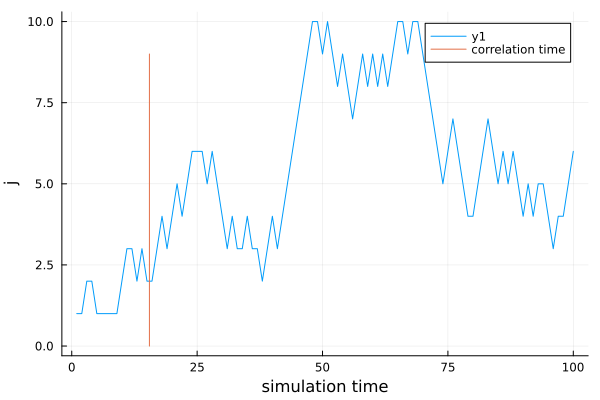

In [25]:
plot(chain1[1:100],xlabel="simulation time",ylabel="j")
plot!([tau1,tau1],[0,9],label="correlation time")

## Calculating Integrals

We now have the background to begin thinking about evaluating integrals.  There are a number of different approaches, and we will not be able to touch on them all.  Suppose we want to calcuates
\begin{equation}
I=\int_\Omega f(\vec{r})\, d\vec{r}
\end{equation}
The typical strategy is to take a probability distribution on $\Omega$, $P_\Omega(\vec{r})$, and write
\begin{equation}
I=\int_\Omega \frac{f(\vec{r})}{P_\Omega(\vec{r})}\,P_\Omega(\vec{r})\, d\vec{r}.
\end{equation}
One then notes that this is just
\begin{equation}
I =\langle \frac{f(\vec{r})}{P_\Omega(\vec{r})}\rangle,
\end{equation}
which you then calculate using sampling.

In the simplest examples, one just takes $P_\Omega$ to be the uniform distribution, 
$P_\Omega(\vec{r})=1/V_\Omega$.  As a simple example, lets do
\begin{align}
I&= \int_{0}^\pi \sin(x) dx\\
&= \int_{0}^\pi \pi \sin(x)\,\frac{dx}{\pi}\\
&= \langle \pi \sin(x)\rangle
\end{align}
where we sample $x$ uniformly

In [42]:
function calcI(nsamples)
    xvalues=pi*rand(nsamples)
    yvalues=@. pi*sin(xvalues)
    Iest=mean(yvalues)
    Ierrest=var(yvalues)/sqrt(length(yvalues))
    return Iest,Ierrest
end

calcI (generic function with 1 method)

In [49]:
calcI(1000)

(1.985667161988883, 0.030220641224832943)

If $P_\Omega(\vec r)\propto f(\vec r)$, then all of the samples will have exactly the same value -- and we get a *zero-variance* estimator -- ie. the exact right answer.  This motivates trying to use a probability distribution which matches $f$ as closely as possible: importance sampling.

To make our life easier, lets write
\begin{equation}
I=\int_0^{\pi/2} 2\sin(x)\,dx
\end{equation}
Lets then sample on $[0,\pi/2]$ with
\begin{equation}
P(x)= \frac{8x}{\pi^2}
\end{equation}
In which case
\begin{equation}
I=\int_0^{\pi/2} \frac{\pi^2\sin(x)}{4x}\,P(x)dx.
\end{equation}
We know we can sample a linear ramp by uniformly sampling $x^2$:

In [55]:
function icalcI(nsamples)
    xvalues=(pi/2)*sqrt.(rand(nsamples))
    yvalues=@. (pi^2/4)*sin(xvalues)/xvalues
    Iest=mean(yvalues)
    Ierrest=var(yvalues)/sqrt(length(yvalues))
    return Iest,Ierrest
end

icalcI (generic function with 1 method)

In [56]:
icalcI(1000)

(1.9993069341549303, 0.002114970900882271)

In [57]:
calcI(1000)

(2.0306339036077494, 0.029673317647073934)

Indeed -- the error bars are about an order of magnitude smaller.